In [1]:
import anndata as ad
import numpy as np
from scvi.model import SCVI


ADATA_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_pbulk_embeds.h5ad"
SCVI_MODEL_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_pbulk_scvi_model/"

adata = ad.read_h5ad(ADATA_PT)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
model = SCVI.load(SCVI_MODEL_PT, adata=adata)

INFO     File /Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_pbulk_sc
         vi_model/model.pt already downloaded                                                


In [3]:
model

SCVI Model with the following params: 
n_hidden: 256, n_latent: 32, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [4]:
# import torch
# import torch.nn as nn

# class Log1pSoftmax(nn.Module):
#     def __init__(self, dim=None):
#         super(Log1pSoftmax, self).__init__()
#         self.softmax = nn.Softmax(dim=dim)
        
#     def forward(self, input):
#         return torch.log1p(self.softmax(input))

# # model = SCVI(adata_train, n_layers=2, n_hidden=64, n_latent=16)
# # model = SCVI(adata_train)
# model.module.decoder.px_scale_decoder[1] = nn.Softplus()
# model.module.decoder.px_scale_decoder[1] = nn.Softmax(dim=-1)
# # model.module.decoder.px_scale_decoder[1] = Log1pSoftmax(dim=-1)

In [5]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [6]:
import scanpy as sc


adata.layers["prediction"] = model.get_normalized_expression(
    library_size=1e5
)
sc.pp.log1p(adata, layer='prediction')

In [7]:
# df = model.differential_expression(groupby='label')
# SCVI_MODEL_DE_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_pbulk_scvi_model_de.csv"
# # TABULA_SAPIENS_BY_CELL_TYPE_SCVI_DE = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_scvi_model_new_norm_de.csv"
# df.to_csv(SCVI_MODEL_DE_PT)

DE...: 100%|██████████| 160/160 [11:21<00:00,  4.26s/it]


In [11]:
# from rosa.preprocessing import add_marker_genes


# adata = add_marker_genes(adata, differential_expression=df)

In [12]:
# adata.write_h5ad(ADATA_PT)

In [13]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap

adata_test, results = score_predictions(adata)


        mean spearmanr across genes 0.822
        mean spearmanr across cells 0.294
        mean square error 0.410
        ks-statistic on total expression 0.356
        mean percent total expression captured per cell 97.188
        


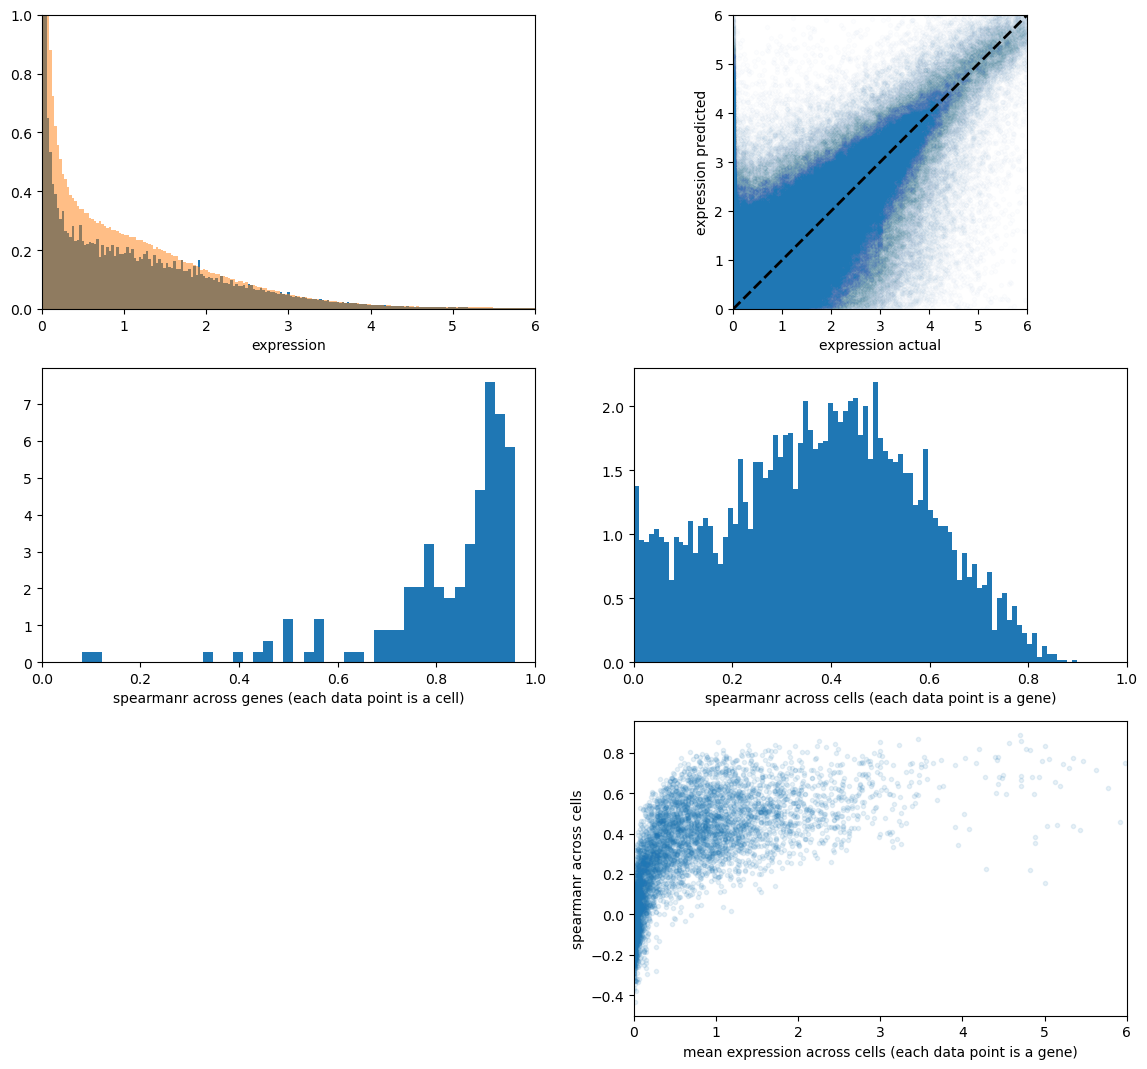

In [14]:
plot_expression_and_correlation(adata_test, results)

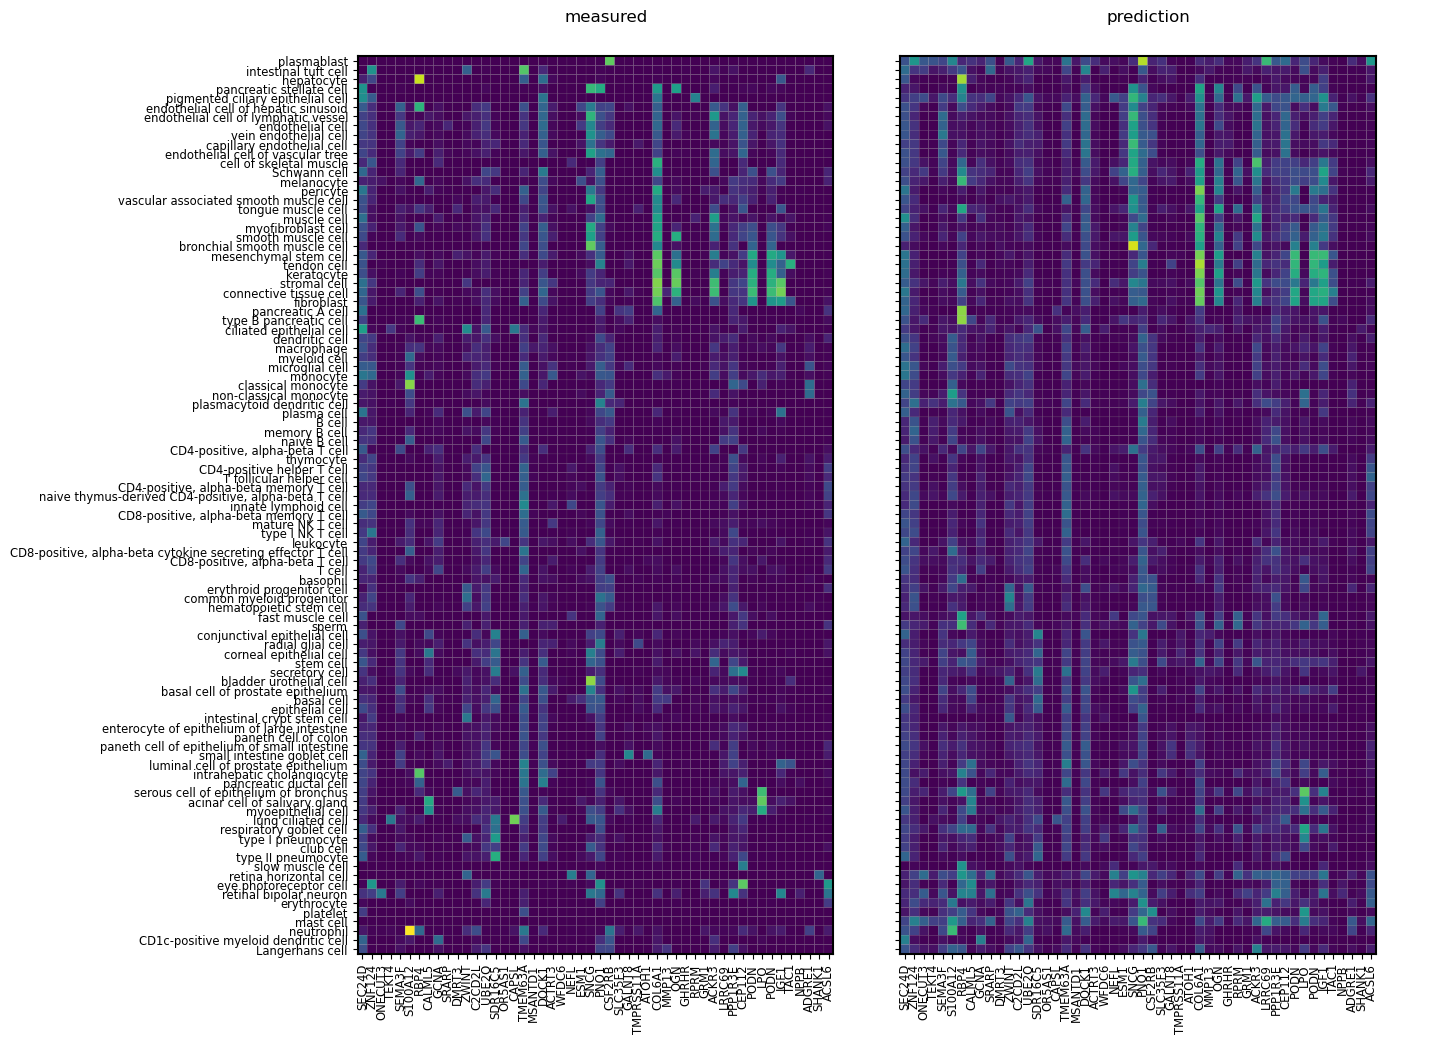

In [15]:
marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

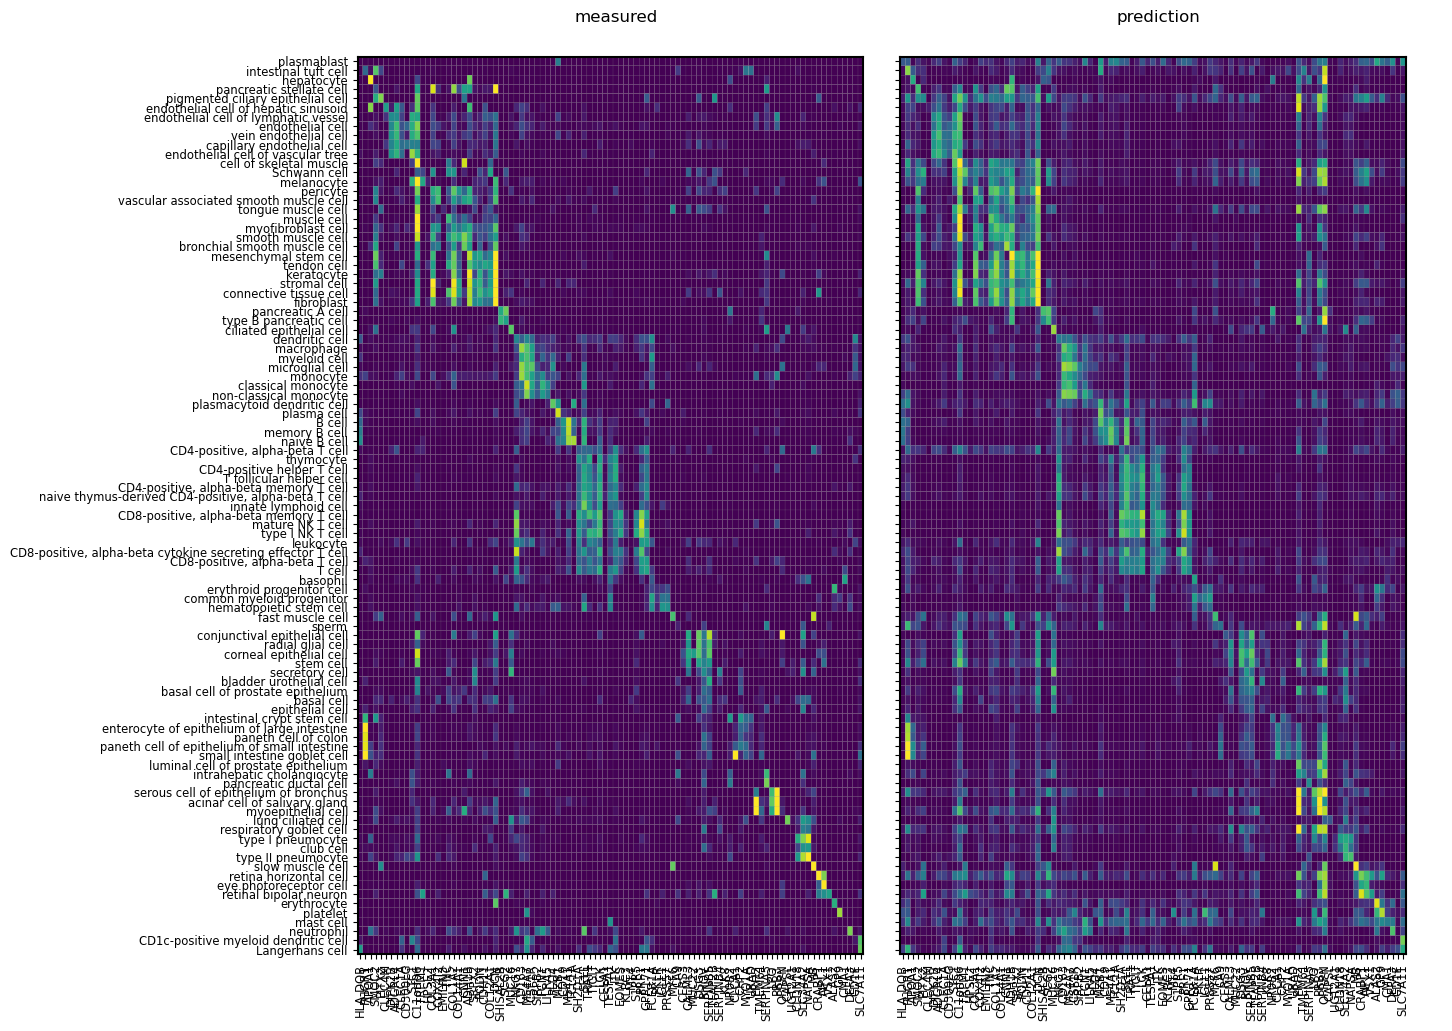

In [16]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)